### First thing to do is to download kaggle dataset using kaggle API ,So I need to authenticate my self by selecting the json file **kaggle.json** that contains my credential data .

In [1]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bahriaymen","key":"a13346c4c42326125bedf0153e4a7d20"}'}

### next step I need to copy the json file to the kaggle directory so I need to create a root directory using the command ***mdir ~/.kaggle*** and I can also add a command to make the file readable only by me by changing the permission using ***chmod ...*** 600 is me (the current user )

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Next I need to download the data set using the command ***kaggle datasets download -d williamscott701/memotion-dataset-7k***

In [3]:
!kaggle datasets download -d williamscott701/memotion-dataset-7k

 97% 673M/695M [00:03<00:00, 200MB/s]
100% 695M/695M [00:03<00:00, 209MB/s]


###Finally, the training data is a compressed file so I need to uncompress it 
###(unzip) silently (-qq):

---



In [4]:
!unzip -qq memotion-dataset-7k.zip

In [5]:
!rm -r /content/memotion_dataset_7k/new_images
!mkdir /content/memotion_dataset_7k/new_images #prepare a new directory to hold our new renamed images later

rm: cannot remove '/content/memotion_dataset_7k/new_images': No such file or directory


###What we will do in the next cell is to open the csv file that contains images names ,their text discription and their lables ,make a dictionnary that for each class i.e positive ,negative etc ,we will save the names of the images belonging to that class 

In [6]:

import os,shutil,pathlib ,csv



label_dict = {}                                                     #this will be a dictionary where we will store  the name of images belonging to each sentiment class that will help us separate eatch class's images 
with open("/content/memotion_dataset_7k/labels.csv","r") as file:
  labels = csv.reader(file)
  next(labels)                                                      #csv.reader returns an iterable ,next will increment the iterrable so we pass the header and we only store image names and their classes
  for row in labels:
    label_dict.setdefault(row[-1],[]).append(row[1])                # for each key ,we append to an empty list the corresponding image name so we get the list of images for each class

""" I will try to rename all the images according to their class and then save them with a jpg extenstion  on a new
                      directory that I'll call new_images a step that  I'll need it later when defining the dataset objects"""


new_name_dict = {}                                                  #creating the new dictionnary names 
for category in list(label_dict.keys()):                            
  for i,name in enumerate(label_dict[category]):                    #each tuple (i,name) will be the name and index of the image that belongs to the  corresponding category   
    extension = name.split(".")[1]                                                    #get image name extension
    src_file = f"/content/memotion_dataset_7k/images/{name}"                              #path to image
    dst_file = f"/content/memotion_dataset_7k/images/{category}_{i}.{extension}"       #path to image with a new name
    os.rename(src_file,dst_file)                                                        #rename the image inside the same directory 

    new_dst = f"/content/memotion_dataset_7k/new_images/{category}_{i}.{extension}"     #the new distination of the renamed image, its a redundant step because the renamed images already exists in the old directory but I don't want to rename the paths later 
    shutil.copyfile(dst_file,new_dst)                                                   #copy the file to the new directory                                                     
    new_name_dict.setdefault(category,[]).append(f"{category}_{i}.{extension}")         #make a new dictionary to hold the new named images that belongs to each class 
    


In [7]:
label_dict_1 = label_dict.copy()                          #copy old images name with their classes 
label_dict = new_name_dict                                 # changes the  names dictionnary with the new names 

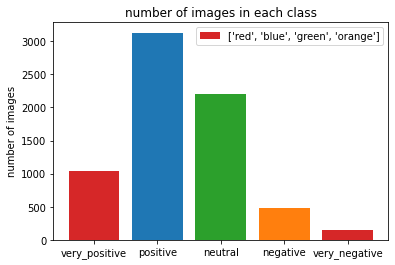

In [8]:
# plot the statistics of each class 
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

classes = list(label_dict.keys())
counts = [len(category) for category in label_dict.values()]
bar_labels = ['red', 'blue', 'green', 'orange']
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']

ax.bar(classes, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('number of images')
ax.set_title('number of images in each class')
ax.legend()

plt.show()

In [9]:
counts

[1033, 3127, 2201, 480, 151]

In [10]:
# now we will use keras functional API to create a CNN model at first,using functional API will allow us to alter the model later by adding layers and enables us to use multi_input architectures

from tensorflow import keras
from keras import layers
inputs =keras.Input(shape = (300,300,3))                                  # input shape (300,300) was chosen at random 
x = layers.Rescaling(1./255)(inputs)                                      # rescaling inputs by deviding each pixel value by 255
x = layers.Conv2D(filters = 32,kernel_size=3,activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)                                   #downsampling the input ,deviding the input shape by 2
x = layers.Conv2D(filters = 64,kernel_size = 3,activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters=128,kernel_size = 3,activation ="relu" )(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters=256,kernel_size = 3,activation ="relu" )(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters=256,kernel_size = 3,activation ="relu" )(x)
x = layers.Flatten()(x)

outputs = layers.Dense(5,activation = "softmax")(x)                     #the classification layer 
model = keras.Model(inputs = inputs,outputs = outputs )

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                         

In [11]:
#Specifying the optimization loop using compile ,by choosing which optimizer to use for example rmsprop,loss function and which metrics to monitor
model.compile(optimizer="rmsprop",loss="sparse_categorical_crossentropy",metrics = ["accuracy"])


In [12]:
!rm -r /content/memotion_dataset_7k/memotion_small   #Just a terminal command to remove recursively my small dataset if its already created
import os,shutil,pathlib

original_dir = pathlib.Path("/content/memotion_dataset_7k/new_images")  #where our renamed images live 
new_base_dir = pathlib.Path("/content/memotion_dataset_7k/memotion_small")#where the new images will be moved with their corrosponding class 

label_dict = new_name_dict

#since data is not split equivalently between classes we will split them manually not following any  rule between validation , train and test 
l_train = {}
train_positive = label_dict["positive"][:2000]
train_very_positive = label_dict["very_positive"][:600]
train_neutral = label_dict["neutral"][:1000]
train_negative = label_dict["negative"][:200]
train_very_negative = label_dict["very_negative"][:100]
l_train["positive"],l_train["very_positive"],l_train["neutral"],l_train["negative"],l_train["very_negative"]= train_positive,train_very_positive, train_neutral, train_negative, train_very_negative



l_test ={}
test_positive = label_dict["positive"][2000:2500]
test_very_positive = label_dict["very_positive"][600:800]
test_neutral = label_dict["neutral"][1000:1800]
test_negative = label_dict["negative"][200:400]
test_very_negative = label_dict["very_negative"][100:125]

l_test["positive"],l_test["very_positive"],l_test["neutral"],l_test["negative"],l_test["very_negative"]= test_positive,test_very_positive, test_neutral, test_negative, test_very_negative


l_validation = {}
validation_positive = label_dict["positive"][2500:]
validation_very_positive = label_dict["very_positive"][800:]
validation_neutral = label_dict["neutral"][1800:]
validation_negative = label_dict["negative"][400:]
validation_very_negative = label_dict["very_negative"][125:]

l_validation["positive"],l_validation["very_positive"],l_validation["neutral"],l_validation["negative"],l_validation["very_negative"]= validation_positive,validation_very_positive, validation_neutral, validation_negative, validation_very_negative

def make_subset(subset_name,image_names):
  """ This function will be used to create train validation and test subdirectories ,each one of them of the 5 classes
                      each class contains the number of images thatwas specified above """
  for category in label_dict.keys():                
    dir = new_base_dir / subset_name / category         #path to our memotion_small/ (train,test,or validation) /(positive ,negative ,very_positive ....)
    os.makedirs(dir)

    for fname in image_names[category]:                           #loop over the images that belongs to each class ,and move them to the appropriate directory 
      shutil.copyfile(src=original_dir /fname,dst=dir / fname)





rm: cannot remove '/content/memotion_dataset_7k/memotion_small': No such file or directory


In [13]:
make_subset("train",l_train)
make_subset("validation",l_validation)
make_subset("test",l_test)

In [14]:
#image_dataset_from_directory will list subdirectories and assume that each directory belongs to a class ,so as directroies are listed as 
#(negative,neutral,positive,very_negative,very_positive) classes will be (0,1,2,3,4) accordingly 

from tensorflow.keras.utils import image_dataset_from_directory

shape = (300,300)

train_dataset = image_dataset_from_directory(new_base_dir /"train",
                                             image_size = shape,batch_size = 32)       # train_dataset will be an iterable that holds the training data as 32 batches with(300,300) shape ,and their corrosponding labels
                                                                                                        
validation_dataset = image_dataset_from_directory(new_base_dir / "validation",
                                                  image_size = shape,batch_size = 32)
test_dataset = image_dataset_from_directory(new_base_dir / "test",
                                            image_size = shape,batch_size = 32)


Found 3899 files belonging to 5 classes.
Found 1367 files belonging to 5 classes.
Found 1725 files belonging to 5 classes.


In [15]:
#to check the data shape in our train dataset object
for data_batch ,labels_batch in train_dataset:
  print(data_batch.shape,labels_batch,labels_batch.shape)
  image = data_batch[0]
  image_label = labels_batch[0]
  break



(32, 300, 300, 3) tf.Tensor([2 1 2 2 0 1 2 2 0 1 4 0 2 2 1 0 2 2 4 0 2 2 2 2 2 1 4 2 1 1 2 2], shape=(32,), dtype=int32) (32,)


(-0.5, 299.5, 299.5, -0.5)

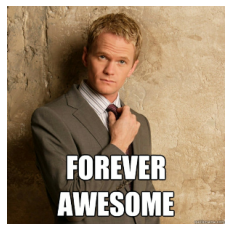

In [16]:
#lets see a reshaped image ,we converted the image to an unsined int array so it can be visualised properly with plt.imshow()
import matplotlib.pyplot as plt
plt.imshow(image.numpy().astype("uint8"))
plt.axis("off")

In [17]:
#we will set a base line of 50% accuracy on training ,and then try to make the model overfit 


callback_list = [keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=2),
                 keras.callbacks.ModelCheckpoint(filepath="checkpoint.keras",monitor="val_accuracy",save_best_only=True)]   #EarlyStopping callback will allow the model to stop fitting as soon as the validation accuracy stalls and save the model 


history = model.fit(train_dataset,epochs=30,validation_data=validation_dataset,callbacks=callback_list)      #history is a dictionnary that will hold the values of accuracy and loss for each epoch 

Epoch 1/30
122/122 [==============================] - 40s 237ms/step - loss: 1.9981 - accuracy: 0.5019 - val_loss: 1.3268 - val_accuracy: 0.4587
Epoch 2/30
122/122 [==============================] - 28s 225ms/step - loss: 1.2530 - accuracy: 0.5127 - val_loss: 1.2732 - val_accuracy: 0.4587
Epoch 3/30
122/122 [==============================] - 27s 215ms/step - loss: 1.2379 - accuracy: 0.5127 - val_loss: 1.2750 - val_accuracy: 0.4587


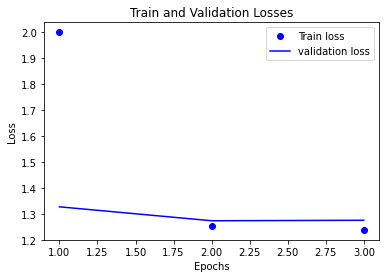

In [18]:
import matplotlib.pyplot as plt
history_dict = history.history
train_loss =history_dict["loss"]
val_loss = history_dict["val_loss"]
epochs = range(1,len(train_loss) + 1)
plt.plot(epochs,train_loss,"bo",label = "Train loss")
plt.plot(epochs,val_loss,"b",label = "validation loss")
plt.title("Train and Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
model.layers

In [20]:
# we will add more layers to the model if it can helps it overfit,as increasing model parametres(simply memory) will genrally make the model discover more patterns

model.layers[10]   # the last convolutuin layer before flatten

In [21]:
x = model.layers[10].output   #store the output of that 10th layer 

# add 2 conv2D and a MAxpooling layer 

x = layers.Conv2D(filters=256,kernel_size = 3,activation ="relu" )(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters=256,kernel_size = 3,activation ="relu" )(x)
x = layers.Flatten()(x)
outputs = layers.Dense(5,activation = "softmax")(x)

model_2 =keras.Model(inputs = inputs,outputs = outputs )  # make a new model 

In [22]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                       

In [27]:
model_2.compile(optimizer="rmsprop",loss="sparse_categorical_crossentropy",metrics = ["accuracy"])


In [28]:

shape = (300,300)

train_dataset = image_dataset_from_directory(new_base_dir /"train",
                                             image_size = shape,batch_size = 32)

validation_dataset = image_dataset_from_directory(new_base_dir / "validation",
                                                  image_size = shape,batch_size = 32)
test_dataset = image_dataset_from_directory(new_base_dir / "test",
                                            image_size = shape,batch_size = 32)


Found 3899 files belonging to 5 classes.
Found 1367 files belonging to 5 classes.
Found 1725 files belonging to 5 classes.


In [29]:
callback_list = [keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=2),
                 keras.callbacks.ModelCheckpoint(filepath="checkpoint.keras",monitor="val_accuracy",save_best_only=True)]
history = model_2.fit(train_dataset,epochs=30,validation_data=validation_dataset,callbacks=callback_list)

Epoch 1/30
122/122 [==============================] - 30s 232ms/step - loss: 1.2681 - accuracy: 0.5073 - val_loss: 1.2691 - val_accuracy: 0.4587
Epoch 2/30
122/122 [==============================] - 28s 219ms/step - loss: 1.3002 - accuracy: 0.5122 - val_loss: 1.2775 - val_accuracy: 0.4587
Epoch 3/30
122/122 [==============================] - 28s 221ms/step - loss: 1.2457 - accuracy: 0.5127 - val_loss: 1.2932 - val_accuracy: 0.4587


### there are no improvments ,the model barely fits the data,there are no clear patterns between the data and the labels 

*   I will make a multi input model where I will feed to it images and the text associated to them 

1.   I will make a densely connected layers first and see how they perform on text without the use of RNNs



*   and then I will use a pretrained model 



In [53]:
text_dict = {}                                                     #this will be a dictionary where I will store  the text discription of each image belonging to each sentiment class 
with open("/content/memotion_dataset_7k/labels.csv","r") as file:
  labels = csv.reader(file)
  next(labels)                                                      #csv.reader returns an iterable ,next will increment the iterrable so I pass the header and I only store image names and their classes
  for row in labels:
    text_dict.setdefault(row[-1],[]).append(row[3].lower())              # for each key ,I append to an empty list the corresponding image text so I get the list of texts for each class



In [54]:
text_dict["positive"][:3]

["sam thorne @strippin ( follow follow saw everyone posting these 2009 vs 2019 pics so here's mine 6:23 pm - 12 jan 2019 o 636 retweets 3 224 likes 65 636 3.2k",
 '10 year challenge - sweet dee edition',
 'fornite died in 10 months but minecraft never died in 10 years i am so proud of this community']

In [55]:
#checking if  each text discription will be linked to the correct image 
text_dict["positive"][0],label_dict_1["positive"][0],label_dict["positive"][0]

("sam thorne @strippin ( follow follow saw everyone posting these 2009 vs 2019 pics so here's mine 6:23 pm - 12 jan 2019 o 636 retweets 3 224 likes 65 636 3.2k",
 'image_3.JPG',
 'positive_0.JPG')

In [71]:
# I need a dictionnary of words to be able to numerically encode the text discriptions so I will use the imdb get_word_index 
from tensorflow.keras.datasets import imdb
word_index = imdb.get_word_index()   #Returns the index of a word inside a dictionnary 

vecto_words = {}
for category in list(text_dict.keys()):
  for i,name in enumerate(text_dict[category]):
      vecto_words.setdefault(category,[]).append([word_index.get(word,0) for word in text_dict[category][i] ]) #get the list of word indexes and replace a missing word index with 0
      #vecto_words[category][i] = [i for i in vecto_words[category][i] if i != 0 ]                               # remove 0 and its occurences 0








In [57]:
# split text data into train,test and validation 

t_train = {}
train_positive = vecto_words["positive"][:2000]
train_very_positive = vecto_words["very_positive"][:600]
train_neutral = vecto_words["neutral"][:1000]
train_negative = vecto_words["negative"][:200]
train_very_negative = vecto_words["very_negative"][:100]
t_train["positive"],t_train["very_positive"],t_train["neutral"],t_train["negative"],t_train["very_negative"]= train_positive,train_very_positive, train_neutral, train_negative, train_very_negative



t_test ={}
test_positive = vecto_words["positive"][2000:2500]
test_very_positive = vecto_words["very_positive"][600:800]
test_neutral = vecto_words["neutral"][1000:1800]
test_negative = vecto_words["negative"][200:400]
test_very_negative = vecto_words["very_negative"][100:125]

t_test["positive"],t_test["very_positive"],t_test["neutral"],t_test["negative"],t_test["very_negative"]= test_positive,test_very_positive, test_neutral, test_negative, test_very_negative


t_validation = {}
validation_positive = vecto_words["positive"][2500:]
validation_very_positive = vecto_words["very_positive"][800:]
validation_neutral = vecto_words["neutral"][1800:]
validation_negative = vecto_words["negative"][400:]
validation_very_negative = vecto_words["very_negative"][125:]

t_validation["positive"],t_validation["very_positive"],t_validation["neutral"],t_validation["negative"],t_validation["very_negative"]= validation_positive,validation_very_positive, validation_neutral, validation_negative, validation_very_negative



In [58]:
import numpy as np
empty_element_indexes = []                                                                   # to store the index of empty sequences 
def load_data(data_name):
    labels = ["negative","neutral","positive","very_negative","very_positive"] # will help me change class names with their corrosponding numbers
    data =[]
    data_labels =[]
    global empty_element_indexes
    for label in labels:                                                         #loop over labels
      for i,elt in enumerate(data_name[label]):                                                # loop over samples of vectored data ,each text was replaced with a vector of indexes before we loop over each vector in each class
        if(len(elt) != 0):                                                        # if the elt is not empty 
          data.append(elt)                                                        # append the value to the list called data 
          data_labels.append(labels.index(label))                                 #append its corresponding numerical label in a diffrent list so we end up with a vector of samples ,and its corresponding vector of numerical lables
        else:
          empty_element_indexes.append(data_name[label].index(elt))               
    return np.asarray(data),np.asarray(data_labels)                               # the tow lists need to converted to numpy array so we can see their shapes 


train_data,train_labels = load_data(t_train)                                      # get train data and its labels using our created funnction
val_data,val_labels = load_data(t_validation)                                     #get the validation data and their labels 



<ipython-input-58-2bf13d0db159>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data),np.asarray(data_labels)                               # the tow lists need to converted to numpy array so we can see their shapes


In [59]:
val_data.shape


(1364,)

In [60]:
# Build a simple 3 layers sequential model 


model_t = keras.Sequential([
    layers.Dense(512,activation="relu"),
    layers.Dense(128,activation="relu"),
    layers.Dense(5,activation="softmax")
])
model_t.compile(optimizer="rmsprop",loss="categorical_crossentropy",metrics=["accuracy"])

In [61]:
dimension = max(max([max(sequence) for sequence in train_data ]) ,max([max(sequence) for sequence in val_data ])) + 1 #search for the largest word index 
dimension

63165

In [62]:

import numpy as np
def vectorize_data(sequences,dimension=63165):
    """ this function will one hot encode each data sample by replacing each value with 1 corresponding to the index value """
    result = np.zeros((len(sequences),dimension))
    for i,sequence in enumerate(sequences):
        for j in sequence:
            result[i,j] = 1.
    return result
x_train = vectorize_data((train_data)) 
x_val = vectorize_data(val_data)
x_train.shape


(3899, 63165)

In [63]:
y_train =np.asarray(train_labels).astype("float32") # transforming labels to array of float32 
y_val = np.asarray(val_labels).astype("float32")

In [64]:
# one hot encoding the labels
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val =  to_categorical(y_val)
y_train.shape

(3899, 5)

In [65]:
history = model_t.fit(x_train,y_train,epochs=30,batch_size=64,validation_data=(x_val,y_val))

Epoch 1/30
61/61 [==============================] - 3s 35ms/step - loss: 1.2537 - accuracy: 0.5083 - val_loss: 1.2822 - val_accuracy: 0.4575
Epoch 2/30
61/61 [==============================] - 2s 25ms/step - loss: 1.2368 - accuracy: 0.5127 - val_loss: 1.2891 - val_accuracy: 0.4575
Epoch 3/30
61/61 [==============================] - 2s 31ms/step - loss: 1.2332 - accuracy: 0.5127 - val_loss: 1.2769 - val_accuracy: 0.4575
Epoch 4/30
61/61 [==============================] - 2s 28ms/step - loss: 1.2318 - accuracy: 0.5127 - val_loss: 1.2912 - val_accuracy: 0.4575
Epoch 5/30
61/61 [==============================] - 2s 26ms/step - loss: 1.2261 - accuracy: 0.5122 - val_loss: 1.3363 - val_accuracy: 0.4575
Epoch 6/30
61/61 [==============================] - 2s 26ms/step - loss: 1.2266 - accuracy: 0.5140 - val_loss: 1.2805 - val_accuracy: 0.4575
Epoch 7/30
61/61 [==============================] - 2s 25ms/step - loss: 1.2235 - accuracy: 0.5127 - val_loss: 1.2780 - val_accuracy: 0.4545
Epoch 8/30
61

### it seems that a sequential model is performing a littel better than the CNN on images which means that the textual data has more clear bonds and patterns than images 

1.   I will Add more layers to the model to improve its power 
2.   I will use the EarlyStop callback to stop training the model as soon the accuracy stalls, and modelcheckpoint callbacks to save the best version of the model as I did in the CNN training  section .



In [66]:
#definig a new model with more layers 
model_t_1 = keras.Sequential([
    layers.Dense(512,activation="relu"),
    layers.Dense(512,activation="relu"),
    layers.Dense(256,activation="relu"),
    layers.Dense(512,activation="relu"),
    layers.Dense(5,activation="softmax")
])
model_t_1.compile(optimizer="rmsprop",loss="categorical_crossentropy",metrics=["accuracy"])

In [67]:
callback_list = [keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=2),
                 keras.callbacks.ModelCheckpoint(filepath="checkpoint_text_model.keras",monitor="val_accuracy",save_best_only=True)]
history = model_t_1.fit(x_train,y_train,epochs=30,batch_size=64,validation_data=(x_val,y_val),callbacks=callback_list)

Epoch 1/30
61/61 [==============================] - 4s 58ms/step - loss: 1.2756 - accuracy: 0.5083 - val_loss: 1.3090 - val_accuracy: 0.4575
Epoch 2/30
61/61 [==============================] - 2s 27ms/step - loss: 1.2471 - accuracy: 0.5127 - val_loss: 1.3629 - val_accuracy: 0.4575
Epoch 3/30
61/61 [==============================] - 2s 26ms/step - loss: 1.2420 - accuracy: 0.5127 - val_loss: 1.2663 - val_accuracy: 0.4575


In [72]:
empty = {}                              #hold the index of empty encoded lists
image_name ,old_image_name = [],[]
vecto_words_1 = vecto_words

for category in vecto_words.keys():
  for i,elt in enumerate(vecto_words[category]):
    if(len(elt) == 0):
      empty.setdefault(category,[]).append(label_dict[category][i])                # images that I need to remove later to solve the labelling conflict in the multiinput model by creating new datasets excluding those images 
      old_image_name.append(label_dict_1[category][i])
      vecto_words_1[category].remove(elt)              #remove empty sequences 


empty,old_image_name






({'positive': ['positive_57.jpg',
   'positive_3038.jpg',
   'positive_3040.jpg',
   'positive_3041.jpg'],
  'neutral': ['neutral_1518.jpg']},
 ['image_120.jpg',
  'image_6781.jpg',
  'image_6783.jpg',
  'image_6784.jpg',
  'image_4800.jpg'])

In [ ]:
#make a new directory by removing the images that had no vectorized text representation 
src_dir = "/content/memotion_dataset_7k/memotion_small"
new_dst ="/content/memotion_dataset_7k/memotion_small_new" 
shutil.copytree(src_dir,new_dst)                           #copy old folder content to the new one

In [81]:
#So we don't alter how we have split the data previously between train,test,and validation we can just remove the images by know where they belong according to their names
#we have a postive inside train and the others inside validation
#we have an image inside test 
l =["train","validation","test"]
for _ in enumerate(l):
  for category in empty.keys():
    for i,name in enumerate(empty[category]):                        #loop over the classes that have empty sequences 
      dir = new_dst + f"/{_[1]} /{category}/{name}"
      try:
        os.remove(dir)                                              #try to remove the file ,if it exists it will be removed
      except :
        print(f"file with  name:{dir} doesn't exist   ")

        







file with  name:/content/memotion_dataset_7k/memotion_small_new/train /positive/positive_57.jpg doesn't exist   
file with  name:/content/memotion_dataset_7k/memotion_small_new/train /positive/positive_3038.jpg doesn't exist   
file with  name:/content/memotion_dataset_7k/memotion_small_new/train /positive/positive_3040.jpg doesn't exist   
file with  name:/content/memotion_dataset_7k/memotion_small_new/train /positive/positive_3041.jpg doesn't exist   
file with  name:/content/memotion_dataset_7k/memotion_small_new/train /neutral/neutral_1518.jpg doesn't exist   
file with  name:/content/memotion_dataset_7k/memotion_small_new/validation /positive/positive_57.jpg doesn't exist   
file with  name:/content/memotion_dataset_7k/memotion_small_new/validation /positive/positive_3038.jpg doesn't exist   
file with  name:/content/memotion_dataset_7k/memotion_small_new/validation /positive/positive_3040.jpg doesn't exist   
file with  name:/content/memotion_dataset_7k/memotion_small_new/validat

### Now we have images and their vectorized  corresponding data we can check if they are consisting by checking their shape 

In [93]:
shape = (300,300)
new_base_dir_1 = pathlib.Path("/content/memotion_dataset_7k/memotion_small_new")

train_dataset = image_dataset_from_directory(new_base_dir_1 /"train",
                                             image_size = shape,batch_size = 32,shuffle = False)      #we won't shuffle the data so we don't loose the link between images and their vectorized text 

validation_dataset = image_dataset_from_directory(new_base_dir_1 / "validation",
                                                  image_size = shape,batch_size = 32,shuffle = False)
test_dataset = image_dataset_from_directory(new_base_dir_1 / "test",
                                            image_size = shape,batch_size = 32,shuffle = False)

Found 3898 files belonging to 5 classes.
Found 1364 files belonging to 5 classes.
Found 1724 files belonging to 5 classes.


In [109]:
train_data = 0
train_lables =0 
for data_batch ,labels_batch in train_dataset:
  train_data = data_batch
  train_labels = labels_batch
  break

# select 32 sample from textual data 
x_train = x_train[:32]
y_train = y_train[:32]

#lets check images labels and text labels 
x_train.shape,train_data.shape



((32, 63165), TensorShape([32, 300, 300, 3]))

### it seems that text alone wont pass the 50% accuracy ,I will now use a model with multi inputs by combining the CNN and the sequential models with the help of the functional API 

In [110]:
input_text = keras.Input(shape=(dimension,),name = "input_text")
input_images = keras.Input(shape=(300,300,3),name = "input_images")

#defining the model that will process text
x = layers.Dense(64,activation="relu")(input_text)
x = layers.Dense(128,activation="relu")(x)
x = layers.Dense(256,activation = "relu")(x)
outputs = layers.Dense(28,activation = "relu")(x)   #intermediate layer to use it for concatination 
model_text = keras.Model(inputs = input_text,outputs = outputs)

#defining the model that will process images I will use the same model as before but with changing the layer that becomes after Flatten
y = layers.Rescaling(1./255)(input_images)                                      # rescaling inputs by deviding each pixel by 255
y = layers.Conv2D(filters = 32,kernel_size=3,activation="relu")(y)
y = layers.MaxPooling2D(pool_size=2)(y)                                   #downsampling the input ,deviding the input shape by 2 and pooling the max value by a 2*2 window
y = layers.Conv2D(filters = 64,kernel_size = 3,activation = "relu")(y)
y = layers.MaxPooling2D(pool_size = 2)(y)
y = layers.Conv2D(filters=128,kernel_size = 3,activation ="relu" )(y)
y = layers.MaxPooling2D(pool_size = 2)(y)
y = layers.Conv2D(filters=256,kernel_size = 3,activation ="relu" )(y)
y = layers.MaxPooling2D(pool_size = 2)(y)
y = layers.Conv2D(filters=256,kernel_size = 3,activation ="relu" )(y)
y = layers.Flatten()(y)

outputs_2 = layers.Dense(28,activation = "relu")(y)
model_images = keras.Model(inputs = input_images,outputs = outputs_2 )

# concatination both model outputs 
features = layers.concatenate([model_images.output,model_text.output])
 
# we finish by adding the classification layer 
outputs_3 = layers.Dense(5,activation="softmax",name = "outputs_3")(features)

final_model = keras.Model(inputs = [input_images,input_text],outputs =outputs_3 )




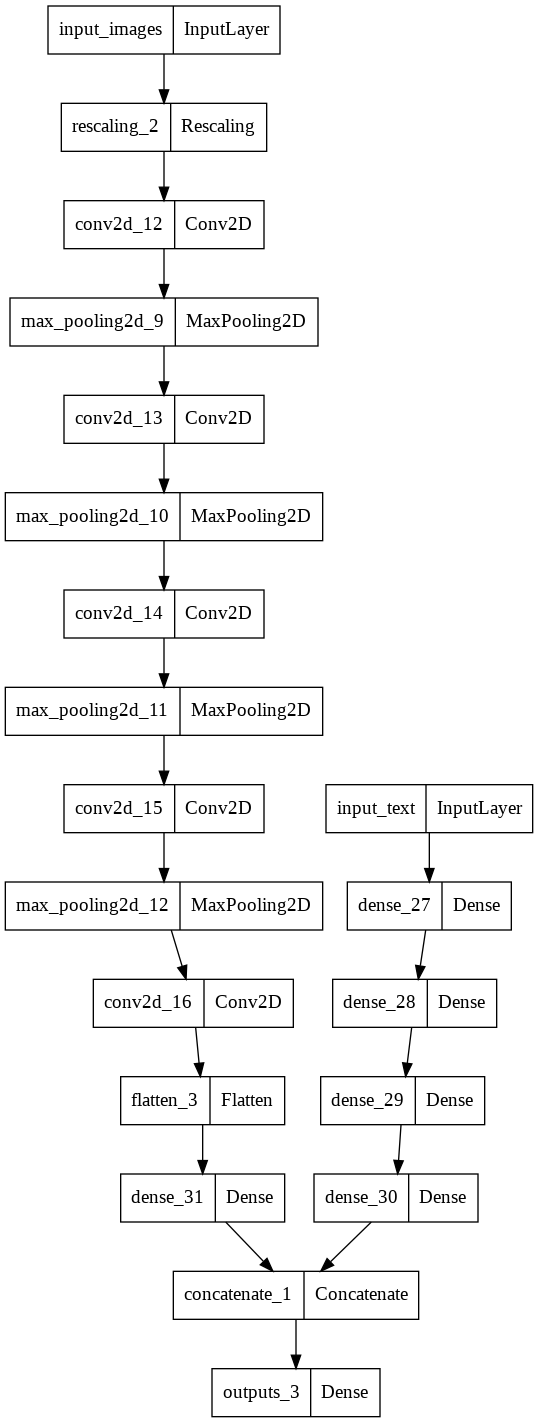

In [111]:
#lets check our model and plot it using the plot_model functionality
keras.utils.plot_model(final_model)

In [114]:
#let us compile and fit the new model 


final_model.compile(optimizer="rmsprop",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = final_model.fit({"input_images":train_data,"input_text":x_train},train_labels,epochs= 10)


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 139ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 117ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 115ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 116ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 114ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 109ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 110ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 107ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 107ms/step - loss: 0.0000e+00 -

### That didn't work becuase the train_dataset object contains the labels and the labels for the text model are not coherent with images 
### we need more time to deal with it but I will skip it becuase there is no time left for the report and to push the notebook 

In [ ]:
# there is no improvments at all I will try to use a pretrained model 
#I will load the VGG16 which is a model trained on the Imagnet dataset that contains 1000 classes so what I need to do is remove the clsiffication layer 
#Frezz the model base weights and retrain the model on my images ,luckilly I can only load the Base by setting te include top to False
new_model_base = keras.applications.vgg16.VGG16(weights="imagenet",include_top=False,input_shape=(300, 300, 3))



58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
new_model_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

### After importing the base model ,we can use its weights and runs it through our dataset ,record the outputs of the process and then use them as an input to another classifier this exactly equivalent to freezing model weights ,adding a densly classification layer to it and fitting it to our data what will happend is the base will output a prediction and the training will be held only on the classification layer 

In [ ]:
def get_features_and_labels(dataset):
    """ This functions runs a prediction over our dataset and record the predicted values in numpy arrays"""
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)   #Preprocessing images which include normalization 
        features = new_model_base.predict(preprocessed_images)                    #predict using the pretrained model base 
        all_features.append(features)                                             #store the predicted values and there labels 
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)




In [ ]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)

1/1 [==============================] - 3s 3s/step


In [ ]:
#lets check the shape of our train_features so we can know what is the shape of data that will be fed to the classifier
train_features.shape

(3899, 9, 9, 512)

## We can now define our  densly connected classifier

In [ ]:
inputs = keras.Input(shape=(9,9,512)) #the input layer
x = layers.Flatten()(inputs)
x = layers.Dense(256,activation = "relu")(x)
outputs = layers.Dense(5,activation ="softmax")(x)

pretrained_model = keras.Model(inputs = inputs,outputs = outputs)


In [ ]:
# complile and fit 
pretrained_model.compile(optimizer="rmsprop",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = pretrained_model.fit(train_features,train_labels,epochs=20,batch_size=128,validation_data=(val_features,val_labels))

Epoch 1/20
31/31 [==============================] - 1s 26ms/step - loss: 4.7870 - accuracy: 0.8736 - val_loss: 38.8353 - val_accuracy: 0.3197
Epoch 2/20
31/31 [==============================] - 1s 18ms/step - loss: 2.4696 - accuracy: 0.9125 - val_loss: 41.3709 - val_accuracy: 0.3643
Epoch 3/20
31/31 [==============================] - 1s 17ms/step - loss: 2.1768 - accuracy: 0.9197 - val_loss: 43.5981 - val_accuracy: 0.3826
Epoch 4/20
31/31 [==============================] - 1s 17ms/step - loss: 2.1067 - accuracy: 0.9143 - val_loss: 45.6690 - val_accuracy: 0.4082
Epoch 5/20
31/31 [==============================] - 1s 18ms/step - loss: 1.8631 - accuracy: 0.9305 - val_loss: 39.9545 - val_accuracy: 0.3650
Epoch 6/20
31/31 [==============================] - 1s 17ms/step - loss: 2.1298 - accuracy: 0.9228 - val_loss: 44.5312 - val_accuracy: 0.3855
Epoch 7/20
31/31 [==============================] - 1s 18ms/step - loss: 2.2272 - accuracy: 0.9195 - val_loss: 43.9270 - val_accuracy: 0.3731
Epoch 

###it seems that using a pretrained model gave excelent resuts 
###but it overfits on training we can see the accury  plot 

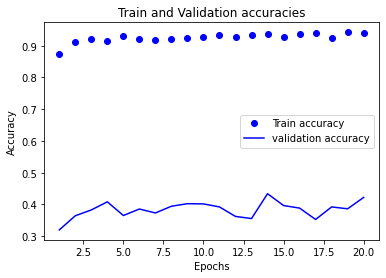

In [ ]:
import matplotlib.pyplot as plt
history = history.history
train_loss =history["accuracy"]
val_loss = history["val_accuracy"]
epochs = range(1,len(train_loss) + 1)
plt.plot(epochs,train_loss,"bo",label = "Train accuracy")
plt.plot(epochs,val_loss,"b",label = "validation accuracy")
plt.title("Train and Validation accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


### it very clear that the model deeply overfits 
### to fit overfittiong we can try to use dropouts by changing the model ,with adding a droput layer before the classification layer

In [ ]:
inputs = keras.Input(shape=(9,9,512)) #the input layer
x = layers.Flatten()(inputs)
x = layers.Dense(256,activation = "relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5,activation ="softmax")(x)

pretrained_model = keras.Model(inputs = inputs,outputs = outputs)

In [ ]:
# complile and fit 
pretrained_model.compile(optimizer="rmsprop",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = pretrained_model.fit(train_features,train_labels,epochs=20,batch_size=128,validation_data=(val_features,val_labels))

Epoch 1/20
31/31 [==============================] - 2s 62ms/step - loss: 26.3434 - accuracy: 0.4039 - val_loss: 1.6555 - val_accuracy: 0.4301
Epoch 2/20
31/31 [==============================] - 1s 22ms/step - loss: 1.5606 - accuracy: 0.5122 - val_loss: 1.8224 - val_accuracy: 0.4579
Epoch 3/20
31/31 [==============================] - 1s 21ms/step - loss: 1.5505 - accuracy: 0.5306 - val_loss: 1.6567 - val_accuracy: 0.4484
Epoch 4/20
31/31 [==============================] - 1s 21ms/step - loss: 1.4569 - accuracy: 0.5306 - val_loss: 2.1623 - val_accuracy: 0.4572
Epoch 5/20
31/31 [==============================] - 1s 21ms/step - loss: 1.5238 - accuracy: 0.5417 - val_loss: 1.7520 - val_accuracy: 0.4484
Epoch 6/20
31/31 [==============================] - 1s 21ms/step - loss: 1.3533 - accuracy: 0.5558 - val_loss: 1.7376 - val_accuracy: 0.4484
Epoch 7/20
31/31 [==============================] - 1s 20ms/step - loss: 1.4016 - accuracy: 0.5619 - val_loss: 1.9334 - val_accuracy: 0.4484
Epoch 8/20
3

### we can see that  the validation accuracy is a littel bit better wich means a less overfittiong ,let us remove the intermediate 256 units layers 
### removing layers or reducing the number of units will make a bottelneck where the model won't be able to overfit 

In [ ]:
inputs = keras.Input(shape=(9,9,512)) #the input layer
x = layers.Flatten()(inputs)
#x = layers.Dense(256,activation = "relu")(x)            ###remove this layer
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5,activation ="softmax")(x)

pretrained_model = keras.Model(inputs = inputs,outputs = outputs)

In [ ]:
# complile and fit 
pretrained_model.compile(optimizer="rmsprop",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = pretrained_model.fit(train_features,train_labels,epochs=20,batch_size=128,validation_data=(val_features,val_labels))

Epoch 1/20
31/31 [==============================] - 1s 39ms/step - loss: 38.7642 - accuracy: 0.3503 - val_loss: 36.0860 - val_accuracy: 0.3599
Epoch 2/20
31/31 [==============================] - 1s 28ms/step - loss: 18.7853 - accuracy: 0.4858 - val_loss: 33.9554 - val_accuracy: 0.4623
Epoch 3/20
31/31 [==============================] - 1s 27ms/step - loss: 11.5988 - accuracy: 0.6045 - val_loss: 24.4576 - val_accuracy: 0.3460
Epoch 4/20
31/31 [==============================] - 1s 26ms/step - loss: 11.3979 - accuracy: 0.6312 - val_loss: 24.6129 - val_accuracy: 0.4111
Epoch 5/20
31/31 [==============================] - 1s 18ms/step - loss: 7.8625 - accuracy: 0.7192 - val_loss: 22.5763 - val_accuracy: 0.3760
Epoch 6/20
31/31 [==============================] - 1s 18ms/step - loss: 5.6151 - accuracy: 0.7740 - val_loss: 26.4664 - val_accuracy: 0.2626
Epoch 7/20
31/31 [==============================] - 1s 17ms/step - loss: 5.9804 - accuracy: 0.7735 - val_loss: 27.4214 - val_accuracy: 0.3775
Ep

###validation accuracy is a littel bit better ,but still very low and the model still overfitts 